# Exploration des données

## Import & fonction

In [7]:
import pandas as pd
import numpy as np
import os
from pathlib import Path 
import missingno as msno
from tabulate import tabulate
from statistics import median, mean, quantiles
import pprint
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import geopy.distance
import folium
import geopy.distance
import prince
from sklearn import preprocessing
from sklearn import cluster
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

plt.style.use('ggplot')
#pd.set_option('max_columns', 200)

## Fonction

In [8]:
# Création d'un DF pour afficher les stats des données
def tstats (data) :
    output = []
    for col in data.columns:
    
        nonNull  = len(data) - np.sum(pd.isna(data[col]))
        nonNullprop = (nonNull / len(data[col]))*100
        unique = data[col].nunique()
        colType = str(data[col].dtype)
        output.append([col, colType, nonNull, round(nonNullprop, 1) , unique])
            
    
    df_stats = pd.DataFrame(output)
    df_stats.columns = ['nom colonne','dtype', 'valeur non null',"% de non null", 'nb_unique']

    print(tabulate(df_stats, headers='keys', tablefmt='psql'))
    
    
def diff_in_hours (date1, date2) :
    result_hour = (date1 - date2) / pd.Timedelta('1 hour')
    return result_hour


def filter_geo_brazil_lat(latitudes):
    filtered_latitudes = []
    default_lat = sum(latitudes) / len(latitudes)
    for lat in latitudes:
         if -33.75 <= lat <= 5.5:
            filtered_latitudes.append(lat)
         else : 
            filtered_latitudes.append(default_lat)            
    return filtered_latitudes


def filter_geo_brazil_lng(longitudes):
    filtered_longitudes = []
    default_lng = sum(longitudes) / len(longitudes)
    for lon in longitudes:
        if -74.5 <= lon <= -34.5:
            filtered_longitudes.append(lon)
        else : 
            filtered_longitudes.append(default_lng)
    return filtered_longitudes

## Intégration des données et fusionner dans un dataframe

In [10]:
path = Path(os.getcwd()) 
p_parent = path.parent
p_customer = str(p_parent) + '\data\olist_customers_dataset.csv'
p_geo = str(p_parent) + '\data\olist_geolocation_dataset.csv'
p_order_item = str(p_parent) + '\data\olist_order_items_dataset.csv'
p_order_payment = str(p_parent) + '\data\olist_order_payments_dataset.csv'
p_order_review = str(p_parent) + '\data\olist_order_reviews_dataset.csv'
p_orders = str(p_parent) + '\data\olist_orders_dataset.csv'
p_products = str(p_parent) + '\data\olist_products_dataset.csv'
p_sellers = str(p_parent) + '\data\olist_sellers_dataset.csv'
p_category = str(p_parent) + '\data\product_category_name_translation_expanded.csv'

customer = pd.read_csv(p_customer)
geo = pd.read_csv(p_geo)
order_item = pd.read_csv(p_order_item)
order_payment = pd.read_csv(p_order_payment)
order_review = pd.read_csv(p_order_review)
orders = pd.read_csv(p_orders)
products = pd.read_csv(p_products)
sellers = pd.read_csv(p_sellers)
category = pd.read_csv(p_category)


#fusion avec .merge

df = orders.merge(customer, on="customer_id", how ='left')\
.merge(order_item, on= "order_id", how = 'left')\
.merge(order_payment, on ='order_id', how ='left')\
.merge(order_review, on ="order_id", how="left")\
.merge(sellers, on ='seller_id', how ="left")\
.merge(products, on = "product_id", how = 'left')\
.merge(category, on="product_category_name", how="left")\


# un erreur lié à la taille du df empeche d'y inclure les données géo
#.merge(geo, left_on ="customer_zip_code_prefix", right_on ='geolocation_zip_code_prefix', how ='inner')\
#.merge(geo, left_on ="seller_zip_code_prefix", right_on ='geolocation_zip_code_prefix', how ='inner')\

# on va créer un autre df pour traiter ces données :

# création de la base des vendeurs :
df_geo_seller = sellers.merge(geo, left_on ="seller_zip_code_prefix", right_on ='geolocation_zip_code_prefix', how ='inner')
#filtre des données hors brezil : 
df_geo_seller['geolocation_lat'] = filter_geo_brazil_lat(df_geo_seller['geolocation_lat'])
df_geo_seller['geolocation_lng'] = filter_geo_brazil_lng(df_geo_seller['geolocation_lng'])
#regroupement des données par vendeur : 
gr_geo_seller = df_geo_seller.groupby(['seller_id'], as_index=False).aggregate({
                'geolocation_lat':'mean',
                'geolocation_lng' : 'mean',
                }).rename(columns={"geolocation_lat": "seller_lat",
                            "geolocation_lng": "seller_lng",
                }) 

# création de la base des clients :
df_geo_customer = customer.merge(geo, left_on ="customer_zip_code_prefix", right_on ='geolocation_zip_code_prefix', how ='inner')
#filtre des données hors brezil :  
df_geo_customer['geolocation_lat'] = filter_geo_brazil_lat(df_geo_customer['geolocation_lat'])
df_geo_customer['geolocation_lng'] = filter_geo_brazil_lng(df_geo_customer['geolocation_lng'])
#regroupement des données par client unique : 
gr_geo_customer = df_geo_customer.groupby(['customer_unique_id'], as_index=False).aggregate({
                'geolocation_lat':'mean',
                'geolocation_lng' : 'mean',
                }).rename(columns={"geolocation_lat": "customer_lat",
                            "geolocation_lng": "customer_lng",
                })
# on ajoute ces nouveaux champ au df principale
df = df.merge(gr_geo_seller, left_on ="seller_id", right_on ='seller_id', how ='left')\
.merge(gr_geo_customer, left_on ="customer_unique_id", right_on ='customer_unique_id', how ='left')

#création d'un liste des nom de colonnes
cols = []

for col in df : 
    cols.append(col)

# transformation des colonnes date en format date

col_date = ['order_purchase_timestamp', 
            'order_approved_at', 
            'order_delivered_carrier_date', 
            'order_estimated_delivery_date',
            'review_creation_date',
            'review_answer_timestamp',
            'shipping_limit_date',
            'order_delivered_customer_date' 
           ]

# modification des type de colonne pour les zip code et les ID

df[col_date] = df[col_date].apply(pd.to_datetime)
df = df.astype({'customer_zip_code_prefix':'object',  'seller_zip_code_prefix' : 'object', "order_item_id": 'object'})

df= df.drop_duplicates()

tstats(df)

+----+-------------------------------+----------------+-------------------+-----------------+-------------+
|    | nom colonne                   | dtype          |   valeur non null |   % de non null |   nb_unique |
|----+-------------------------------+----------------+-------------------+-----------------+-------------|
|  0 | order_id                      | object         |            119143 |           100   |       99441 |
|  1 | customer_id                   | object         |            119143 |           100   |       99441 |
|  2 | order_status                  | object         |            119143 |           100   |           8 |
|  3 | order_purchase_timestamp      | datetime64[ns] |            119143 |           100   |       98875 |
|  4 | order_approved_at             | datetime64[ns] |            118966 |            99.9 |       90733 |
|  5 | order_delivered_carrier_date  | datetime64[ns] |            117057 |            98.2 |       81018 |
|  6 | order_delivered_custo

## Exploration des données

<AxesSubplot:>

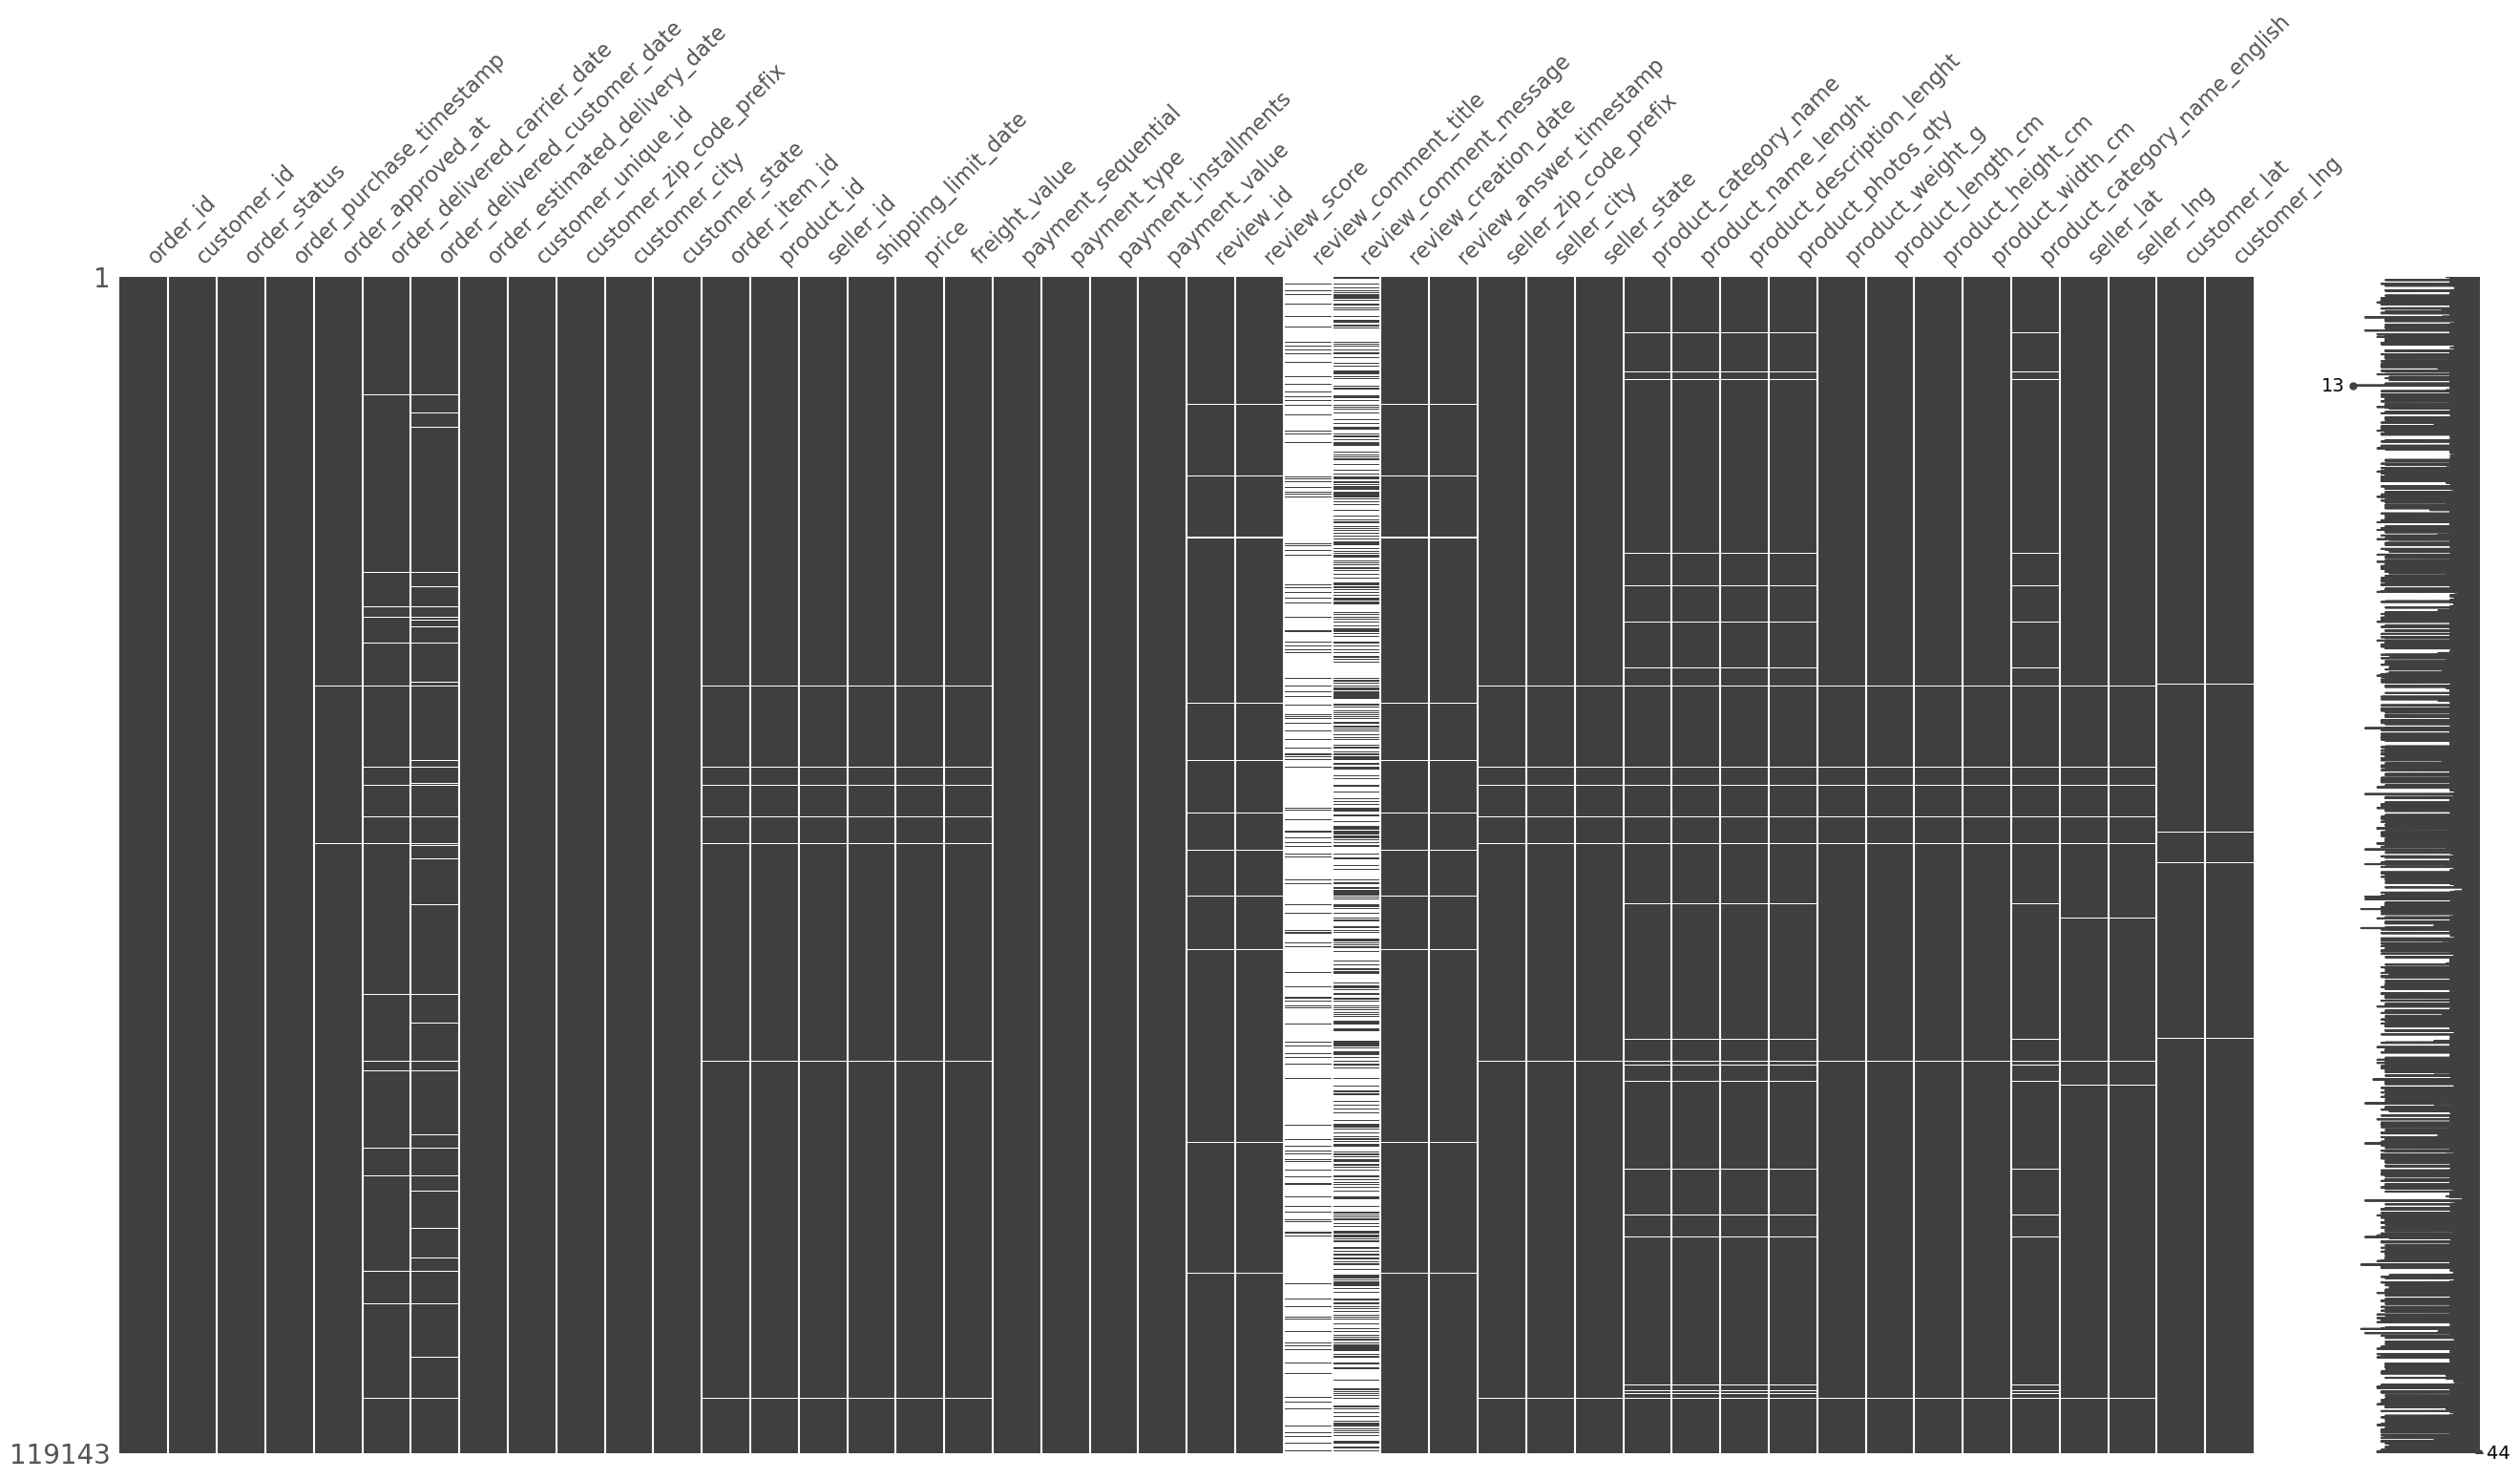

In [11]:
#Graph pour visualiser les NaN
msno.matrix(df, figsize=(32,16))

On peut voir que les champs sont relativement bien remplis a l'exeption de "review_comment_title" et "review_comment_message"

Certaines lignes semble également cumuler de nombreux NaN il faudrait investiguer un peu plus

<AxesSubplot:>

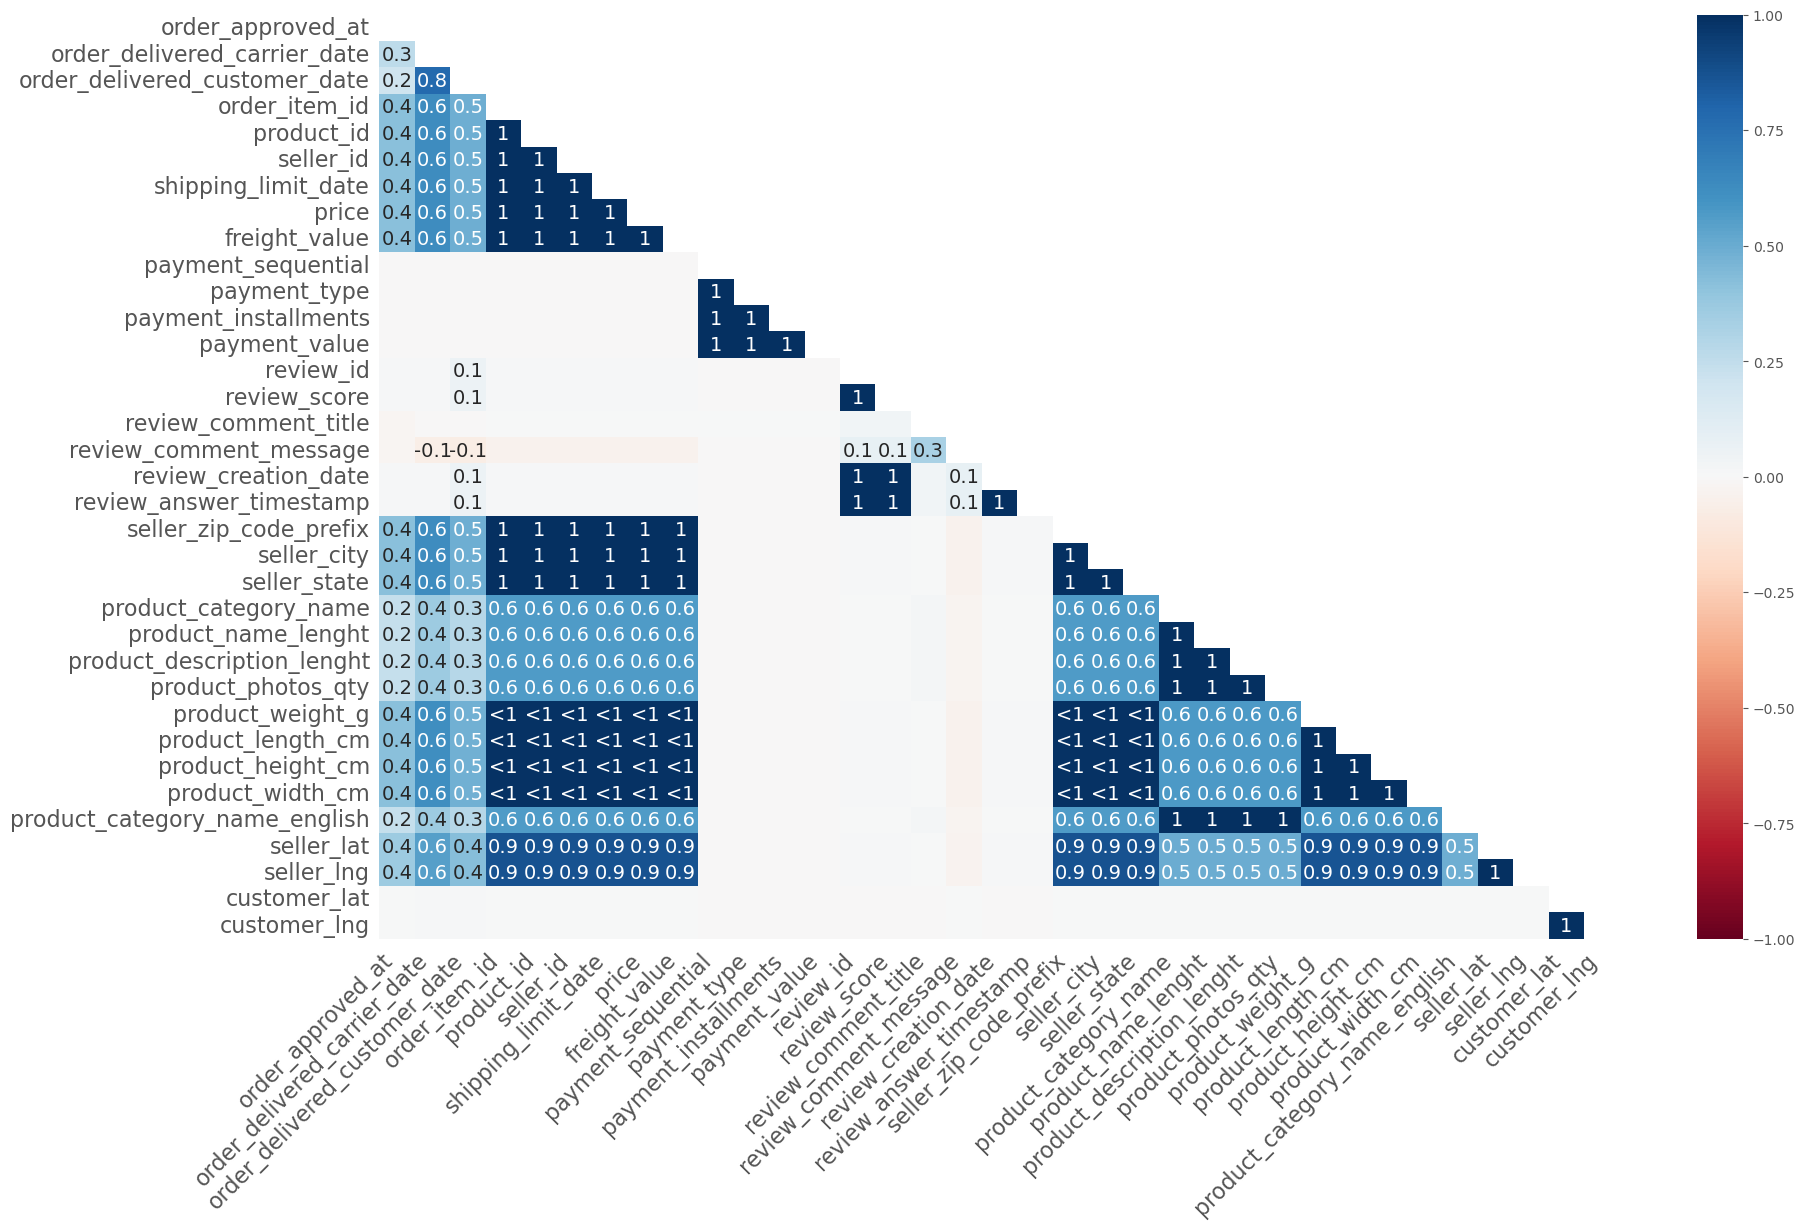

In [12]:
msno.heatmap(df)

La heatmap de msno montre les corrélations entre données manquantes. Un 1 indique que si un information manque dans une colonne, alors elle manquera également dans l'autre. Le -1 serait une anticorrélation.

On peut voir ici que lorsque order_delivered_customer_date est manquantes, order_delivered_carrier_date est souvent manquantes aussi.


## extraction des lignes suspectes

Cette étape a été désactivé après rectification des merges.

In [13]:
#stats des lignes avec des données manquantes : 
df['number_of_NaNs'] = df[cols].isna().sum(1)
df["number_of_NaNs"].describe()

count    119143.000000
mean          1.764367
std           2.094390
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max          31.000000
Name: number_of_NaNs, dtype: float64

In [14]:
number_of_NaNs = df.number_of_NaNs.value_counts().sort_index()
print(number_of_NaNs)

0     11530
1     37662
2     64412
3      1307
4       709
5        76
6      1502
7      1005
8        56
9        17
10       15
11       17
12        1
13        1
22       40
23      468
24      255
25       50
26        1
28       14
29        4
31        1
Name: number_of_NaNs, dtype: int64


<AxesSubplot:>

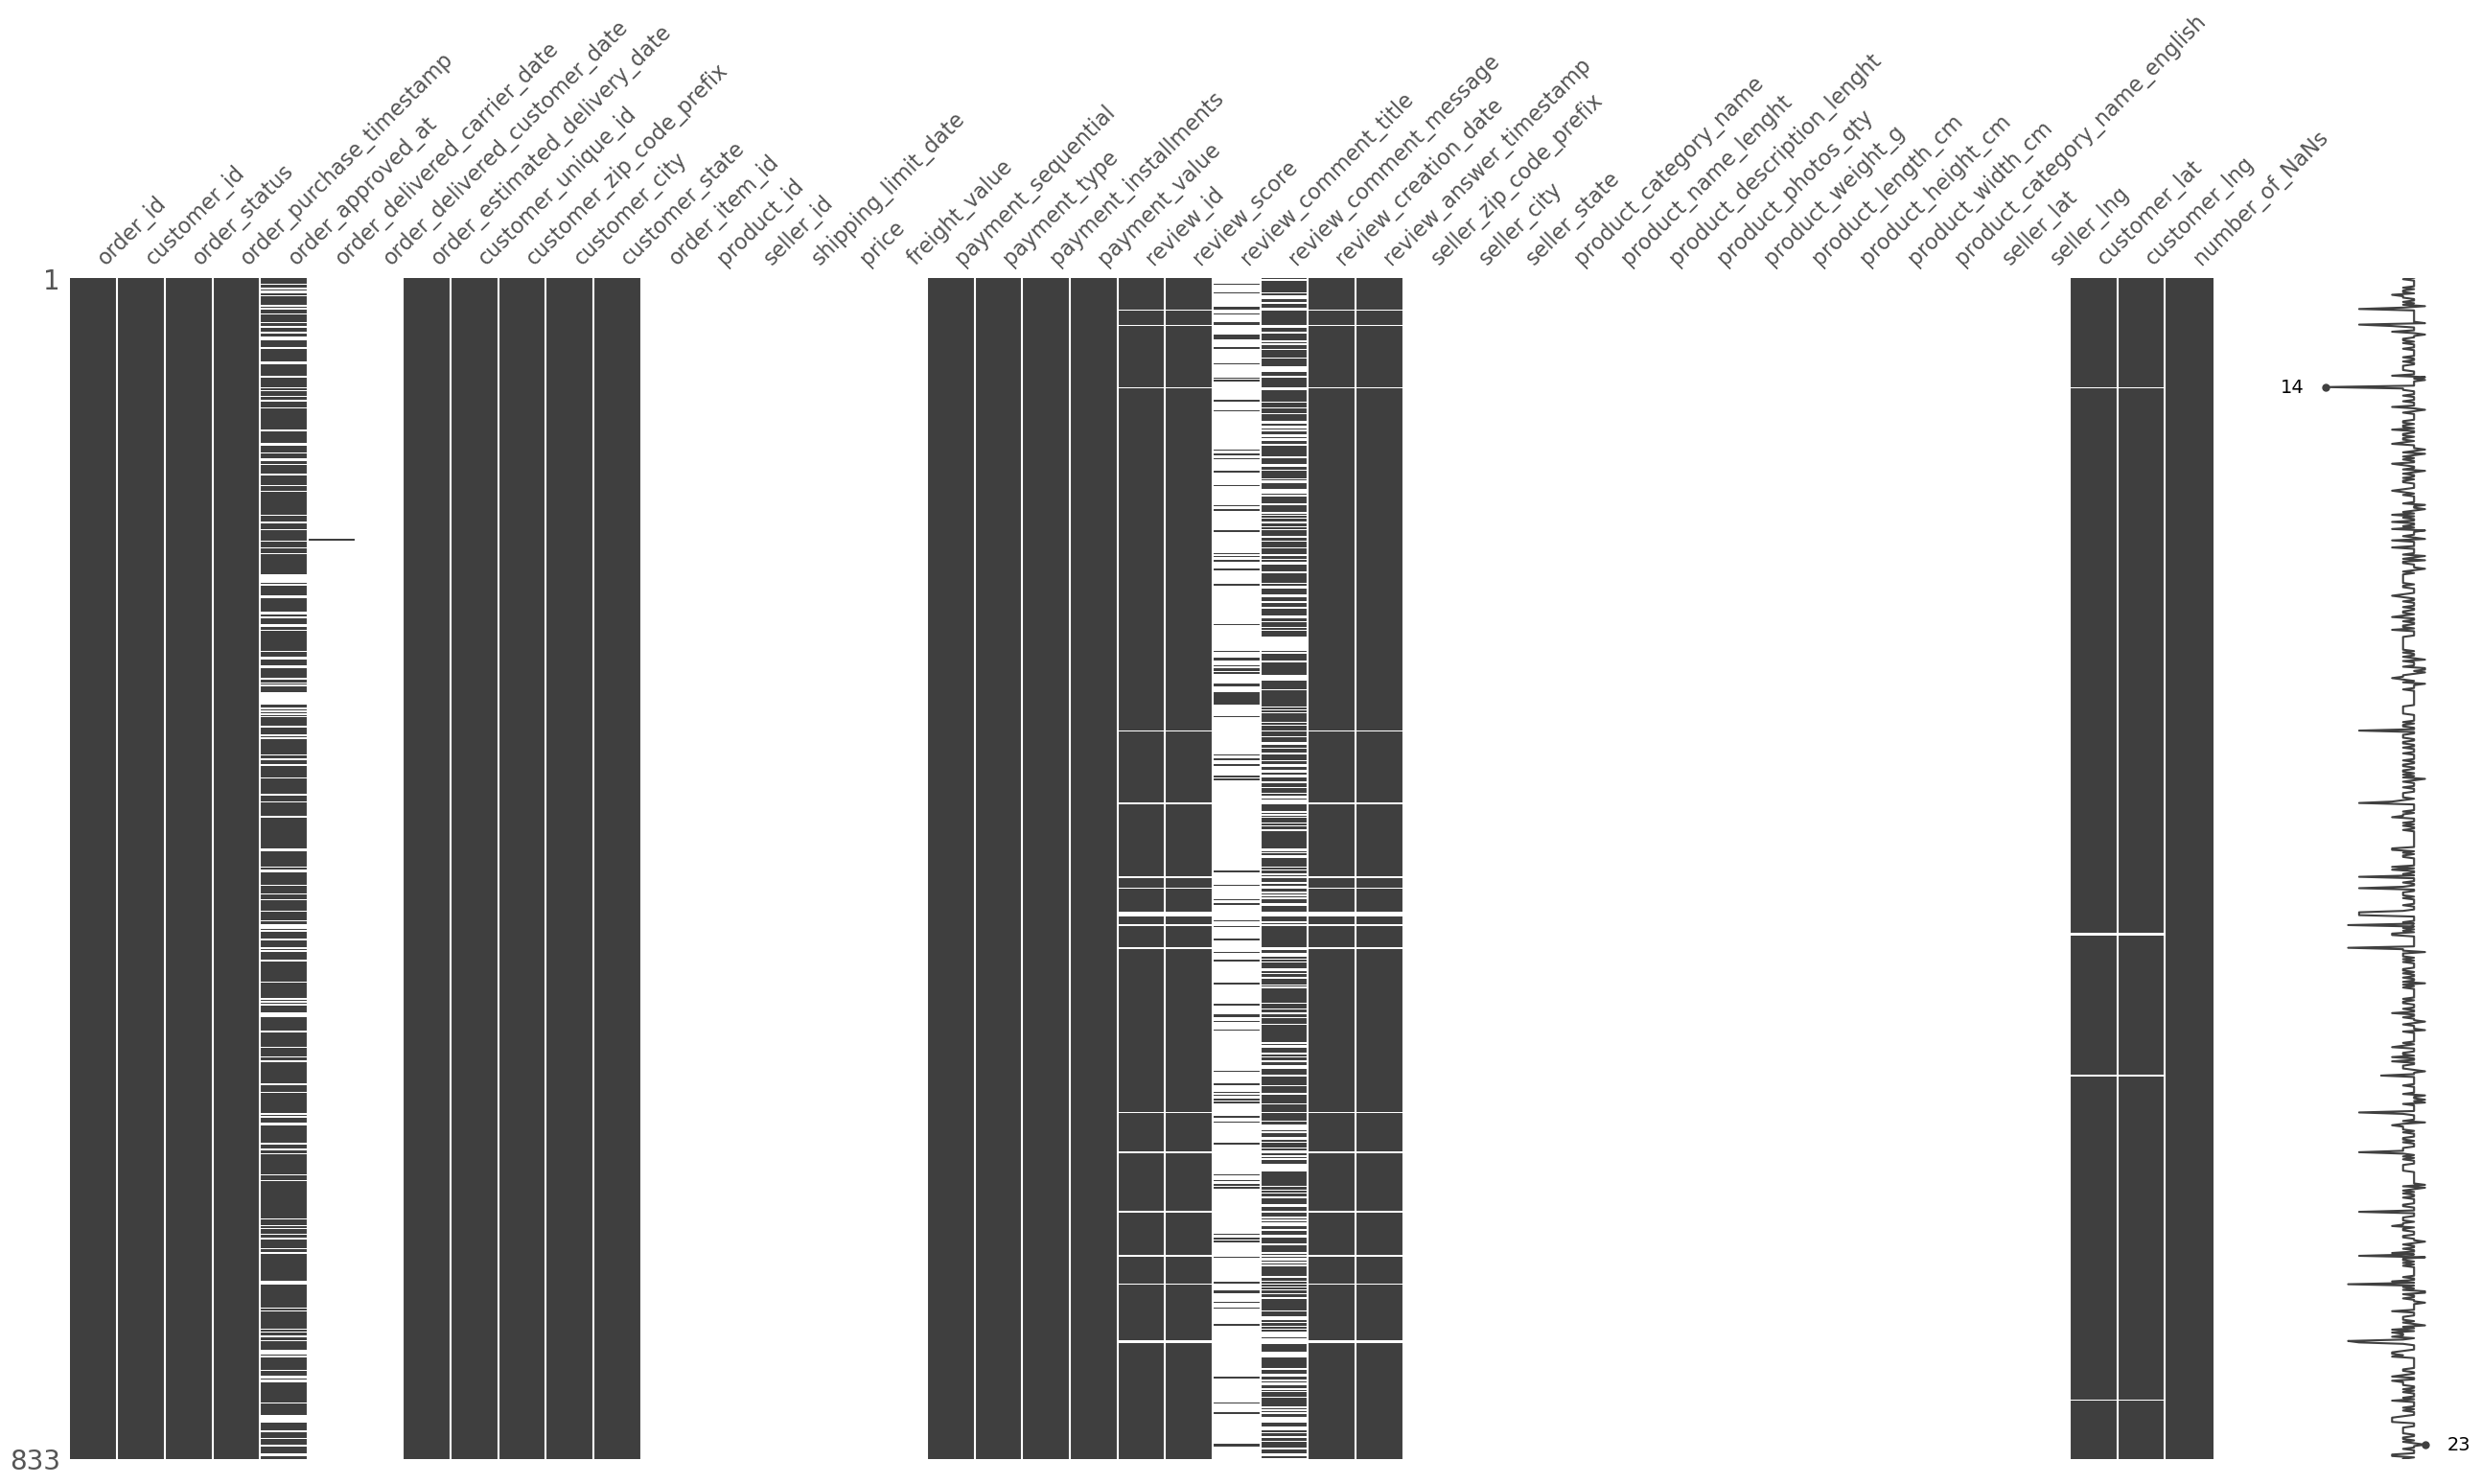

In [15]:
#on voit que plusieurs centaines de lignes ont 20 ou + de donnée manquante sur leur ligne.
high_nan_row = df[df['number_of_NaNs'] >= 20]
msno.matrix(high_nan_row, figsize=(32,16))

In [16]:
#Parmis les lignes où il manque le plus de données on peut voir que ce sont les colonnes provenant des fichiers 
#
#- order_item.csv 
#- product.csv
#- sellers.csv
#
#Au vu des relations entre les table, le problème viens probablement de la jointure entre order et order_item sur order_id
#(product et sellers dépendent de order_item)

#La colonne order_status semble avoir des valeurs spécifiques

high_nan_order_status = high_nan_row["order_status"].value_counts()
df_order_status = df["order_status"].value_counts()
ratio_order_status = high_nan_order_status /df_order_status *100

df_stats_order_status = pd.concat([df_order_status, high_nan_order_status, ratio_order_status], axis=1)
df_stats_order_status.columns = ['Order status_df', 'order_status_high_nan', 'ratio']
df_stats_order_status.head()

,Order status_df,order_status_high_nan,ratio
delivered,115723,NaN,NaN
shipped,1256,1.0,0.079618
canceled,750,180.0,24.000000
unavailable,652,645.0,98.926380
invoiced,378,2.0,0.529101


In [17]:
#On peut voir que 98% des commandes qui ont le status 'unavailable' ont de nombreuses données manquantes, de meme que 24% des commandes 'canceled'
#Ces lignes pourronts être exclues si on cherche les 'bon clients', elle pourront éventuellement être prise en compte si on cherche les 'mauvais clients'
#Dans cette démarche on peurra étudier si des clients sont sur-représenté dans ces catégories  de "order status"

client_bad_orderstatus = df[(df['order_status'] == "canceled") | (df['order_status'] == "unavailable")]
tstats(client_bad_orderstatus)

+----+-------------------------------+----------------+-------------------+-----------------+-------------+
|    | nom colonne                   | dtype          |   valeur non null |   % de non null |   nb_unique |
|----+-------------------------------+----------------+-------------------+-----------------+-------------|
|  0 | order_id                      | object         |              1402 |           100   |        1234 |
|  1 | customer_id                   | object         |              1402 |           100   |        1234 |
|  2 | order_status                  | object         |              1402 |           100   |           2 |
|  3 | order_purchase_timestamp      | datetime64[ns] |              1402 |           100   |        1232 |
|  4 | order_approved_at             | datetime64[ns] |              1245 |            88.8 |        1090 |
|  5 | order_delivered_carrier_date  | datetime64[ns] |                80 |             5.7 |          74 |
|  6 | order_delivered_custo

In [ ]:
# on peut voir que 1220 clients ont des commandes en status unknown ou canceled.

In [22]:
client_bad_orderstatus = client_bad_orderstatus.value_counts("customer_unique_id")

client_bad_orderstatus = (client_bad_orderstatus_nb.groupby(['customer_unique_id', 'review_id'], as_index=False).count()
            .groupby('customer_unique_id')['review_id'].count())
print(client_review.value_counts().sort_index())

NameError: name 'client_bad_orderstatus_nb' is not defined

### Nombre de commande par client

In [7]:
client_order = (df.groupby(['order_id', 'customer_unique_id'], as_index=False).count()
            .groupby('customer_unique_id')['order_id'].count())
print(client_order.value_counts().sort_index())

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
Name: order_id, dtype: int64


On peut voir que la majorité des clients ont commandé qu'une fois. Il faudrait sans doute analyser les clients ayant commandé de multiples fois séparément.

### Nombre de review par client

In [8]:
client_review = (df.groupby(['customer_unique_id', 'review_id'], as_index=False).count()
            .groupby('customer_unique_id')['review_id'].count())
print(client_review.value_counts().sort_index())

1     92659
2      2503
3       172
4        28
5         7
6         6
7         3
8         1
17        1
Name: review_id, dtype: int64


On peut voir que la majorité des clients n'ont laissé qu'une review. 

## Nombre group by Customer

In [9]:
gr_customer = df.groupby(['customer_unique_id'], as_index=False).aggregate({
                'customer_unique_id' : 'nunique',
                'order_id':'nunique',
                'price' : 'sum',
                'review_id':'nunique',
                'review_score':'mean',
                'product_id' : 'count',
                'seller_id' : 'nunique'
                })

round(gr_customer.describe())

,customer_unique_id,order_id,price,review_id,review_score,product_id,seller_id
count,96096.0,96096.0,96096.0,96096.0,95380.0,96096.0,96096.0
mean,1.0,1.0,149.0,1.0,4.0,1.0,1.0
std,0.0,0.0,249.0,0.0,1.0,1.0,0.0
min,1.0,1.0,0.0,0.0,1.0,0.0,0.0
25%,1.0,1.0,48.0,1.0,4.0,1.0,1.0
50%,1.0,1.0,90.0,1.0,5.0,1.0,1.0
75%,1.0,1.0,160.0,1.0,5.0,1.0,1.0
max,1.0,17.0,13440.0,17.0,5.0,75.0,10.0


Les 96096 clients ont chacun :
- réalisé entre 1 et 17 commande, 
- pour un total de 1 à 75 produits
- chez 0 à 10 vendeurs différents
- dépensé un montant compris entre 0 et 13440, 
- laissé entre 0 et 17 review 
- avec une moyenne comprise entre 1 et 5

## Nombre group by Category

In [47]:
gr_category = df.groupby(['metacategory']).aggregate({
    
    'price' : 'sum',
    'customer_unique_id' : 'nunique',
    'review_id':'nunique',
    'review_score':'mean',
    'order_id':'nunique',
    'order_item_id' :'count',
    'product_id' : 'count',
    'seller_id' : 'nunique'
    })


print(gr_category.sort_values(by=['price'], ascending =False ))

                        price  customer_unique_id  review_id  review_score  \
metacategory                                                                 
Home supply        4312839.25               30875      31469      3.959494   
Health and beauty  2153403.51               14654      14799      4.109266   
High tech          1986695.73               15065      15173      3.958899   
Other              1876610.87               11965      12008      4.118235   
Fashion            1402743.88                6574       6612      4.061749   
Sport supply       1029603.88                7515       7656      4.107470   
Tools               362647.91                1924       1921      4.035788   
Books               156215.13                 998       1002      4.359266   
Food and Drinks      69505.72                 961        967      4.192405   
Art                   6961.26                  65         66      4.216216   

                   order_id  order_item_id  product_id  seller_

On peut voir que les catégories ayant généré le plus de ventes sont : 
 - health_beauty :
     - 2153403.51 de revenu 
     - 14897 commande
     - 14654 clients différents 
     -16864 produits au total 
     -784 vendeurs différents
     -14799 reviews à 4.1 de moyenne, 

In [242]:
### Exploration valeur numérique
###a voir la pertinance


#   df_num= df.select_dtypes(include=["int64", "float64"])
#   #df_num.drop(columns=['customer_zip_code_prefix', 'seller_zip_code_prefix', "order_item_id"], inplace = True)
#   output = []
#   for col in df_num.columns:
#   
#       nonNull  = len(df) - np.sum(pd.isna(df[col]))
#       nonNullprop = (nonNull / len(df[col]))*100
#       unique = df[col].nunique()
#       colType = str(df[col].dtype)
#       min = np.min(df[col])
#       max = np.max(df[col])
#       moyenne = round(np.nanmean(df[col]),2)
#       quantile25 = np.nanquantile(df[col],0.25)
#       quantile5 = np.nanquantile(df[col],0.5)
#       quantile75 = np.nanquantile(df[col],0.5)
#       std = round(np.nanstd(df[col]),2)
#       var = round(np.nanvar(df[col]),2)
#       output.append([col, min, max, quantile25, quantile5, quantile75, std, var]) 
#           
#   df_stats = pd.DataFrame(output)
#   df_stats.columns = ['nom colonne', "min", "max", 'quantile.25', 'median', 'quantile.75', 'std', 'var']
#   
#   
#   pp = pprint.PrettyPrinter(indent=4)
#   #print(tabulate(df_stats, headers='keys', tablefmt='psql'))
#   pp.pprint(df_stats)

In [12]:
#   review_score_heatmap = df.corr()['review_score'].to_frame().sort_values('review_score', ascending=False)
#   review_score_heatmap = review_score_heatmap.drop(['review_score'])
#   sns.heatmap(review_score_heatmap, annot=True)
#   plt.title("Order_ID Correaltions to Review Score")
#   plt.show()

In [13]:
#  sns.pairplot(df)

# Feature Engineering

Dans cette partie, nous allons créer de nouvelles variables à partir des données de base qui pourront nous aider a mieux comprendre les différents comportement des clients.

## Date features 

### Buying frequency

In [23]:
# Ordrer the data set by customer ID and Ordering date: 
df = df.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])

# Calcul of time diff between 2 successive order :
df['buy_date_diff'] = df.groupby('customer_unique_id')['order_purchase_timestamp'].diff()

# Convert into days and set to 0 all the customer who only ordered once
df['buy_freq'] = df['buy_date_diff'].dt.days
df['buy_freq'] = df['buy_freq'].fillna(0)

# group by to get the average frequency per customer

avg_buy_freq = df.groupby('customer_unique_id')['buy_freq']\
    .mean().reset_index()\
    .rename(columns={'buy_freq': 'Avg Buying Frequency'})

# the result is the average number of days between 2 order for a customer.
avg_buy_freq.describe()

,Avg Buying Frequency
count,96096.000000
mean,1.121853
std,10.847308
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,304.000000


In [24]:
df["tapproved"] = diff_in_hours(df['order_approved_at'], df['order_purchase_timestamp'])
df['testimate'] = diff_in_hours(df['order_estimated_delivery_date'], df['order_delivered_customer_date'])
df['totaltime'] = diff_in_hours(df['order_delivered_customer_date'], df['order_purchase_timestamp'])
df['treview'] =  diff_in_hours(df['review_creation_date'], df['order_delivered_customer_date'])

### Transport feature

In [25]:
#Du ratio du prix lié au transport
df['ratio_transport_cost'] = df["price"] / df["freight_value"]

In [26]:
for label, row in df.iterrows() : 
    if pd.notna(row['seller_lat']) & pd.notna(row['seller_lng']) & pd.notna(row['customer_lat']) & pd.notna(row['customer_lng']):
        customer_location = [row['seller_lat'], row['seller_lng']]
        seller_location = [row['customer_lat'], row['customer_lng']]
        df.loc [label, "delivery_distance"] = geopy.distance.geodesic(customer_location, seller_location).km
df["transport_cost_per_km"] = df["freight_value"] / df["delivery_distance"]

## Order status feature

In [62]:
df['order_status'].describe()

count        119143
unique            8
top       delivered
freq         115723
Name: order_status, dtype: object

In [95]:
subset_order_status = df[["customer_unique_id", "order_status"]]

In [96]:
dm_order_status = pd.get_dummies(subset_order_status, columns=['order_status'])

In [97]:
gr_order_status = dm_order_status.groupby(['customer_unique_id']).aggregate({
    'order_status_approved' : 'sum',
    'order_status_canceled' : 'sum',
    'order_status_created':'sum',
    'order_status_delivered':'sum',
    'order_status_invoiced':'sum',
    'order_status_processing' :'sum',
    'order_status_shipped' : 'sum',
    'order_status_unavailable' : 'sum'
    })

In [118]:
gr_order_status["ratio_delivered"] = gr_order_status["order_status_delivered"] /     \
np.sum(gr_order_status,axis=1)

In [128]:
notOnlyDelivered = gr_order_status[gr_order_status["ratio_delivered"] != 1]

In [131]:
gr_order_status = dm_order_status.groupby(['customer_unique_id']).aggregate({
    'order_status_canceled' : 'sum',
    'order_status_delivered':'sum',
    'order_status_unavailable' : 'sum'
    })

In [132]:
gr_order_status["ratio_delivered"] = gr_order_status["order_status_delivered"] /     \
np.sum(gr_order_status,axis=1)

In [133]:
notOnlyDelivered = gr_order_status[gr_order_status["ratio_delivered"] != 1]

In [135]:
notOnlyDelivered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2848 entries, 00172711b30d52eea8b313a7f2cced02 to fffcc512b7dfecaffd80f13614af1d16
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_status_canceled     2848 non-null   uint8  
 1   order_status_delivered    2848 non-null   uint8  
 2   order_status_unavailable  2848 non-null   uint8  
 3   ratio_delivered           1220 non-null   float64
dtypes: float64(1), uint8(3)
memory usage: 52.8+ KB


# Customer Focus: 

In [10]:
rd_test1 = df.copy().groupby(['customer_unique_id'], as_index=True).aggregate({
                'order_id':'nunique',
                'price' : 'sum',
                'review_id':'nunique',
                'review_score':'mean',
                'product_id' : 'count',
                'seller_id' : 'nunique',
                'tapproved' : 'mean',
                'testimate' : 'mean',
                'totaltime' : 'mean',
                'treview' : 'mean',
                'buy_freq' : 'mean',
                'delivery_distance' : 'mean',
                'ratio_transport_cost' : 'mean',
                'transport_cost_per_km' : 'mean'
                }).rename(columns={"customer_unique_id": "customer_unique_id",
                            "order_id": "nb_order",
                            "price": "total_spend", 
                            "review_id" : "nb_review", 
                            "review_score": "mean_review", 
                            "product_id": "total_nb_product", 
                            "seller_id": "total_nb_sellers",
                            "tapproved": "temps_approbation",
                            "testimate": "erreur_estimation_livraison",
                            "totaltime": "temps_commande_livraison",
                            "treview": "temps_livraison_review"}) 

In [117]:
tstats(rd_test1)

+----+-----------------------------+---------+-------------------+-----------------+-------------+
|    | nom colonne                 | dtype   |   valeur non null |   % de non null |   nb_unique |
|----+-----------------------------+---------+-------------------+-----------------+-------------|
|  0 | nb_order                    | int64   |             96096 |           100   |           9 |
|  1 | total_spend                 | float64 |             96096 |           100   |        9067 |
|  2 | nb_review                   | int64   |             96096 |           100   |          10 |
|  3 | mean_review                 | float64 |             95380 |            99.3 |          66 |
|  4 | total_nb_product            | int64   |             96096 |           100   |          28 |
|  5 | total_nb_sellers            | int64   |             96096 |           100   |           9 |
|  6 | temps_approbation           | float64 |             95997 |            99.9 |       34146 |
|  7 | err

<AxesSubplot:>

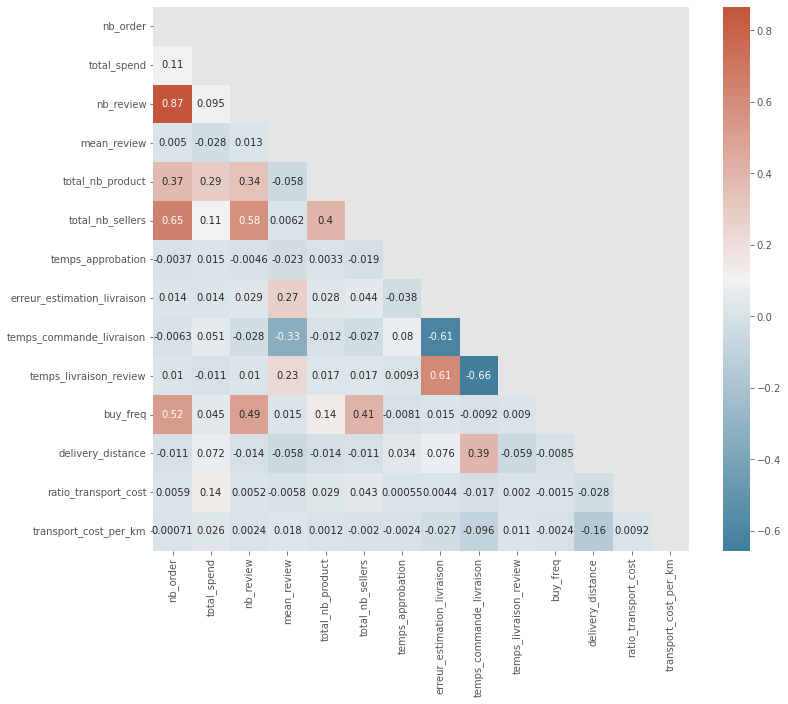

In [17]:
corr = rd_test1.corr()
# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(12, 10))
# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

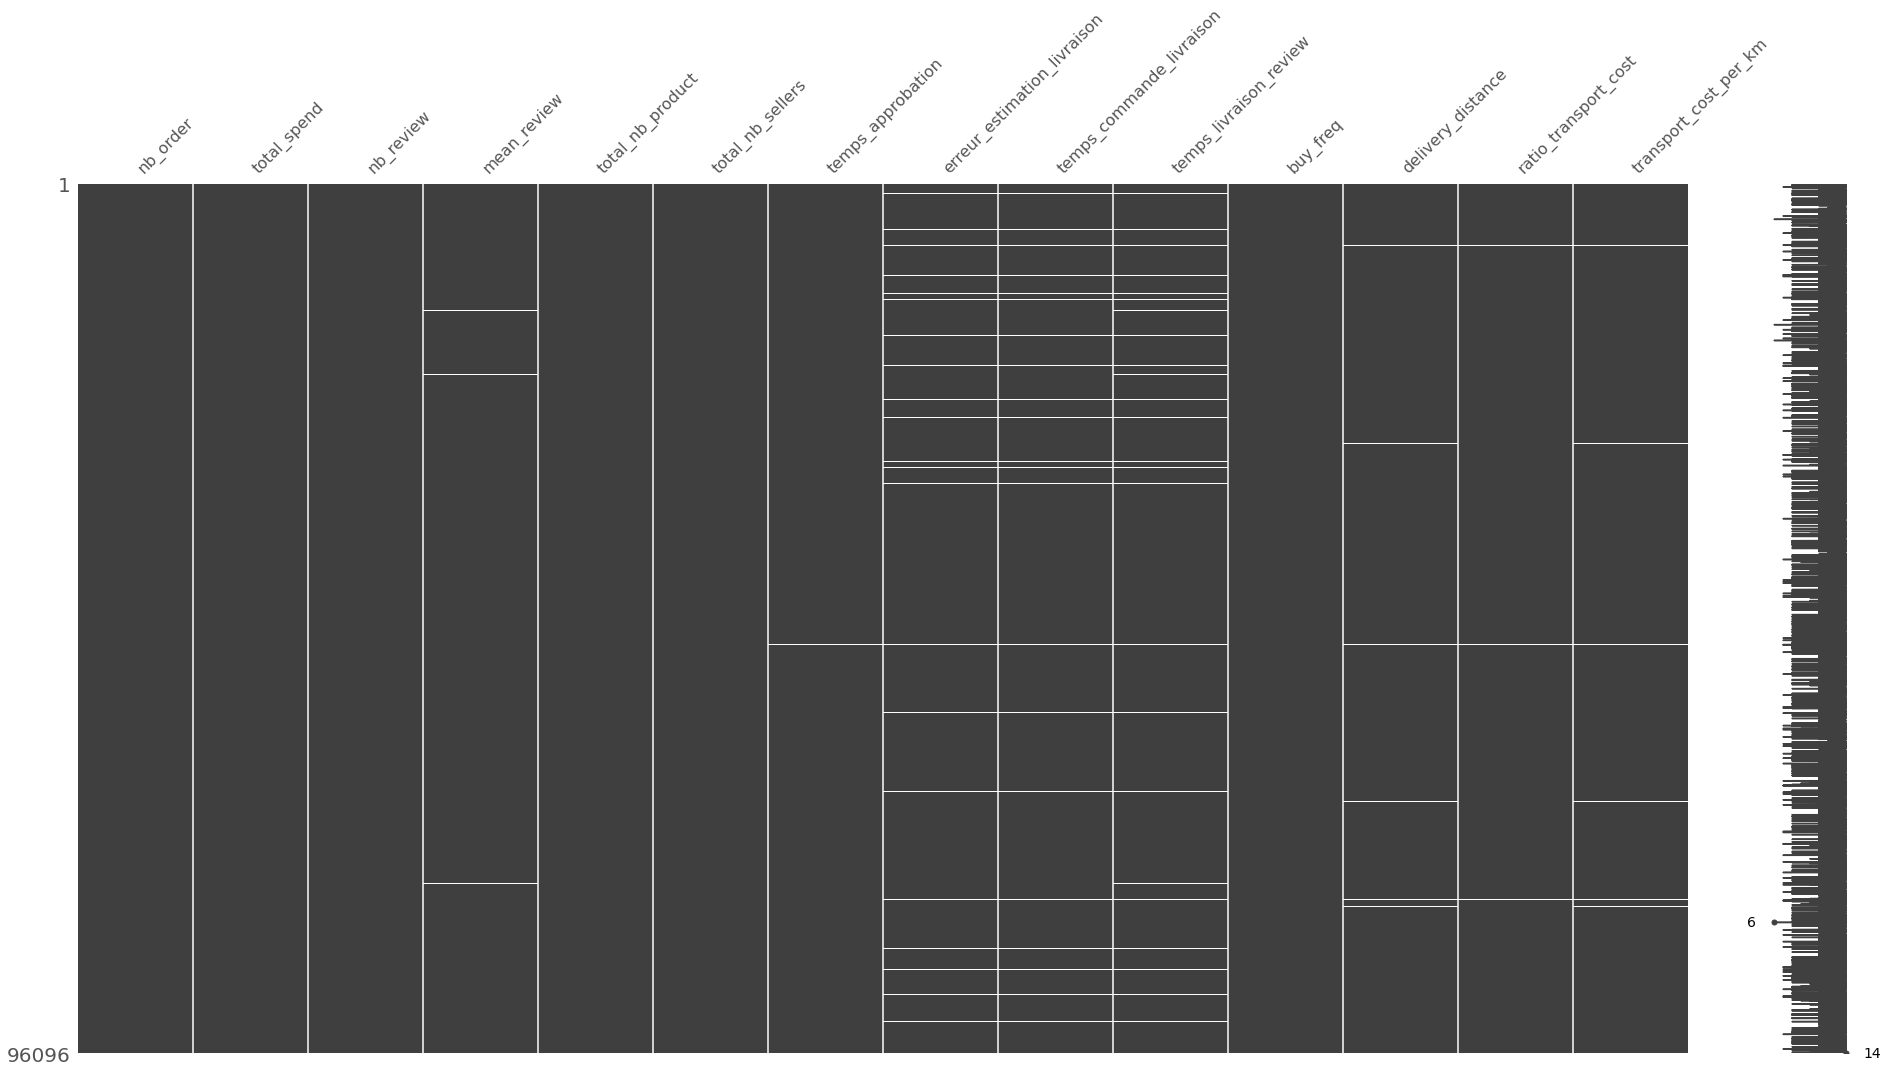

In [26]:
msno.matrix(rd_test1, figsize=(32,16))
rd_test1= rd_test1.dropna()

## Analyse des correspondances Multiples

In [34]:
rd_test1.describe()

,nb_order,total_spend,nb_review,mean_review,total_nb_product,total_nb_sellers,temps_approbation,erreur_estimation_livraison,temps_commande_livraison,temps_livraison_review,buy_freq,delivery_distance,ratio_transport_cost,transport_cost_per_km
count,92245.000000,92245.000000,92245.000000,92245.000000,92245.000000,92245.000000,92245.000000,92245.000000,92245.000000,92245.000000,92245.000000,92245.000000,9.224500e+04,9.224500e+04
mean,1.035731,148.620743,1.032479,4.152029,1.240143,1.038864,10.286760,268.632085,300.423149,-5.874243,1.158924,600.088251,inf,inf
std,0.217363,244.996926,0.207787,1.280896,0.850306,0.219533,20.456633,241.805894,227.090219,110.800059,11.034011,590.014313,NaN,NaN
min,1.000000,0.850000,1.000000,1.000000,1.000000,1.000000,0.000000,-4535.401944,12.801944,-4487.401944,0.000000,0.000000,4.662644e-02,0.000000e+00
25%,1.000000,48.900000,1.000000,4.000000,1.000000,1.000000,0.216389,153.874167,162.507778,2.883056,0.000000,189.774792,2.656239e+00,2.490447e-02
50%,1.000000,89.900000,1.000000,5.000000,1.000000,1.000000,0.346944,285.661944,245.038889,5.687222,0.000000,434.303576,4.485861e+00,4.129218e-02
75%,1.000000,159.900000,1.000000,5.000000,1.000000,1.000000,14.593056,389.622222,375.486389,8.944722,0.000000,797.365401,7.636364e+00,9.031449e-02
max,17.000000,13440.000000,17.000000,5.000000,75.000000,10.000000,741.443611,3504.386944,5000.442222,1587.627778,304.000000,3385.007955,inf,inf


In [35]:
rd_test = rd_test1.drop(['ratio_transport_cost','transport_cost_per_km'], axis = 1)

In [157]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [36]:
clean_dataset(rd_test1)

,nb_order,total_spend,nb_review,mean_review,total_nb_product,total_nb_sellers,temps_approbation,erreur_estimation_livraison,temps_commande_livraison,temps_livraison_review,buy_freq,delivery_distance
customer_unique_id,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1.0,129.90,1.0,5.0,1.0,1.0,0.247500,99.189722,153.869444,3.189722,0.0,110.496092
0000b849f77a49e4a4ce2b2a4ca5be3f,1.0,18.90,1.0,4.0,1.0,1.0,7.238056,101.955000,78.854167,5.955000,0.0,22.190341
0000f46a3911fa3c0805444483337064,1.0,69.00,1.0,3.0,1.0,1.0,0.000000,33.353611,617.562222,9.353611,0.0,515.379484
0000f6ccb0745a6a4b88665a16c9f078,1.0,25.99,1.0,4.0,1.0,1.0,0.326667,266.615278,480.890000,2.615278,0.0,2468.983992
0004aac84e0df4da2b147fca70cf8255,1.0,180.00,1.0,5.0,1.0,1.0,0.352778,168.851111,315.387222,0.851111,0.0,154.744091
...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1.0,1570.00,1.0,5.0,2.0,1.0,0.244444,638.633333,660.356667,14.633333,0.0,1990.407282
fffea47cd6d3cc0a88bd621562a9d061,1.0,64.89,1.0,4.0,1.0,1.0,0.140000,49.527778,722.340000,1.527778,0.0,1523.628196
ffff371b4d645b6ecea244b27531430a,1.0,89.90,1.0,5.0,1.0,1.0,0.224444,707.248889,356.930000,11.248889,0.0,1524.922045


In [45]:
# effectuer une MCA sur les données clients
#mca = prince.MCA(n_components=2, n_iter=3, copy=True, check_input=True, engine='auto', random_state=42)
#mca = mca.fit(rd_test_sd)

## Kmeans

In [145]:
Km_data = df.copy().groupby(['customer_unique_id'], as_index=True).aggregate({

                'price' : 'sum',
                'review_id':'nunique',
                'review_score':'mean',

                'seller_id' : 'nunique',

                'testimate' : 'mean',
                'totaltime' : 'mean',

                'buy_freq' : 'mean',

                }).rename(columns={"customer_unique_id": "customer_unique_id",
                            "order_id": "nb_order",
                            "price": "total_spend", 
                            "review_score": "mean_review", 
                            "product_id": "total_nb_product", 
                            "seller_id": "total_nb_sellers",
                            "testimate": "erreur_estimation_livraison",
                            "totaltime": "temps_commande_livraison"})

In [158]:
clean_dataset(Km_data)

,total_spend,review_id,mean_review,total_nb_sellers,erreur_estimation_livraison,temps_commande_livraison,buy_freq
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,129.90,1.0,5.0,1.0,99.189722,153.869444,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1.0,4.0,1.0,101.955000,78.854167,0.0
0000f46a3911fa3c0805444483337064,69.00,1.0,3.0,1.0,33.353611,617.562222,0.0
0000f6ccb0745a6a4b88665a16c9f078,25.99,1.0,4.0,1.0,266.615278,480.890000,0.0
0004aac84e0df4da2b147fca70cf8255,180.00,1.0,5.0,1.0,168.851111,315.387222,0.0
...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1570.00,1.0,5.0,1.0,638.633333,660.356667,0.0
fffea47cd6d3cc0a88bd621562a9d061,64.89,1.0,4.0,1.0,49.527778,722.340000,0.0
ffff371b4d645b6ecea244b27531430a,89.90,1.0,5.0,1.0,707.248889,356.930000,0.0


In [159]:
Km_data_sc = preprocessing.scale(Km_data)

In [160]:
res = cluster.KMeans(n_clusters=4)

In [161]:
res.fit(Km_data_sc)

KMeans(n_clusters=4)

In [162]:
res.predict(Km_data_sc)

array([0, 0, 2, ..., 0, 0, 0])

In [163]:
res.labels_

array([0, 0, 2, ..., 0, 0, 0])

In [165]:
np.unique(res.labels_, return_counts=True)

(array([0, 1, 2, 3]), array([70409,  2162,  5652, 14530], dtype=int64))

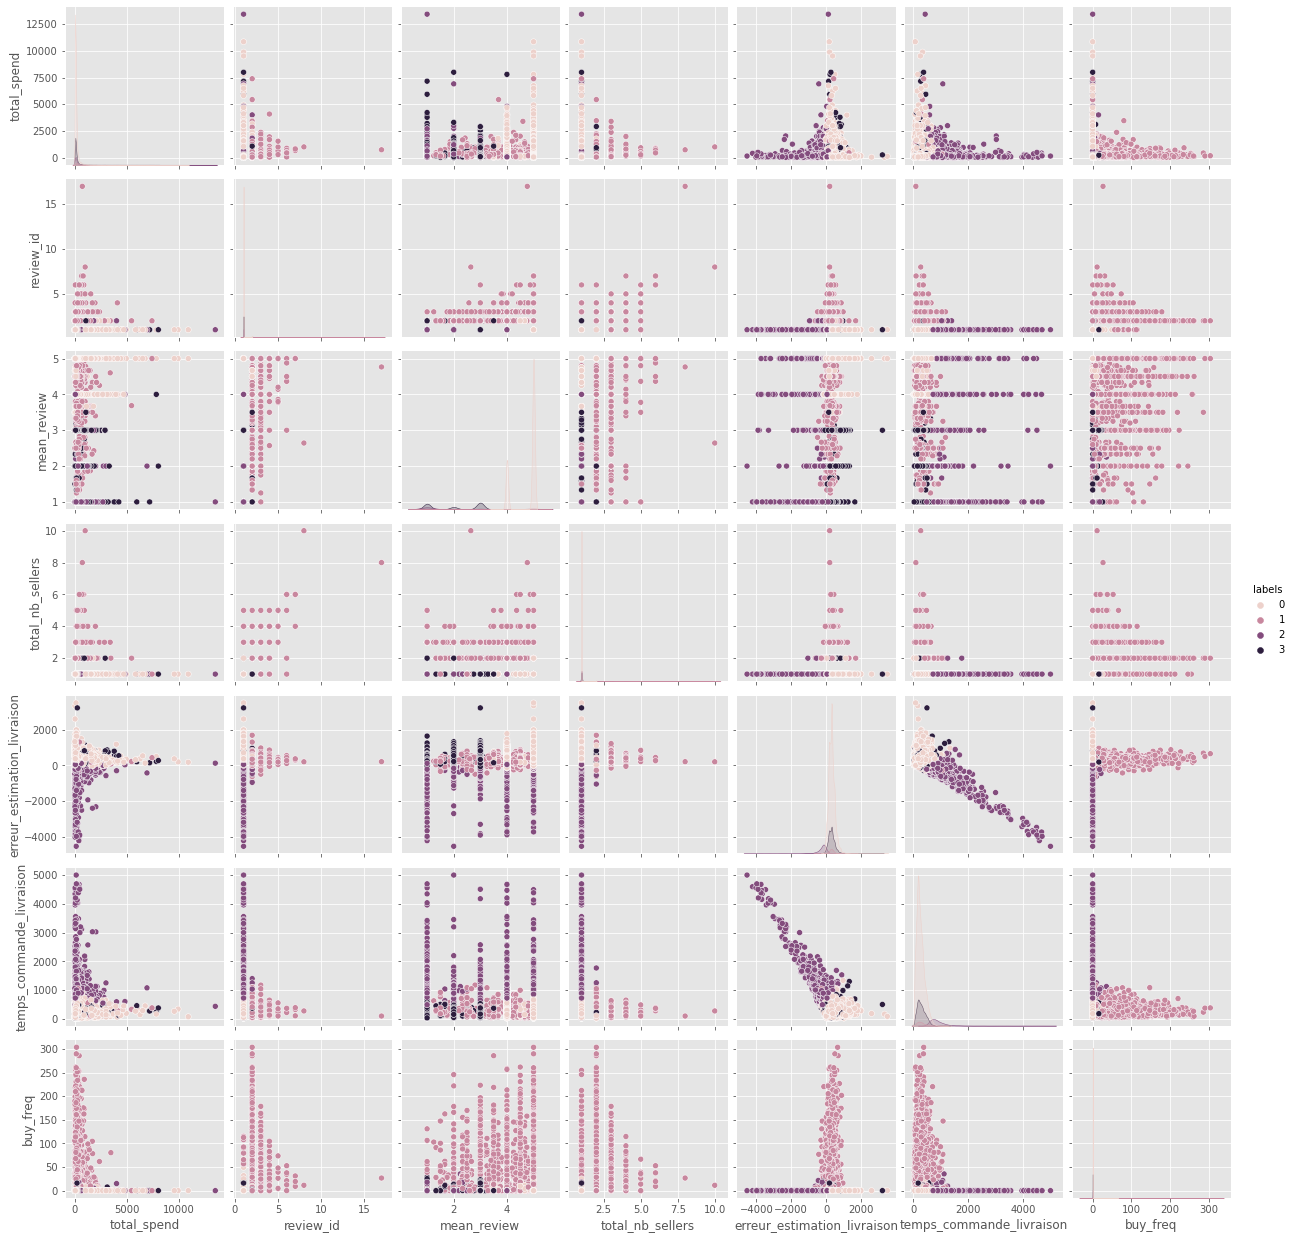

In [166]:
# Rajouter la variable au data-frame initial
Km_data_c = Km_data.copy()
Km_data_c['labels'] = res.labels_
# Configuration des points dans le plan
# Des variables prises par paires
sns.pairplot(Km_data_c,hue="labels")

voir : http://localhost:8889/lab/tree/Cours/Cours/Cour%20Stats/module%205/KMeans_clusters_fromage.ipynb


## Méthode d'optimisation:(méthode du coude et silhouette /  Indice de Davies-Bouldin)

## Méthode du coude : détermination du meilleur K